<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Viz-points-in-2d" data-toc-modified-id="Viz-points-in-2d-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Viz points in 2d</a></span><ul class="toc-item"><li><span><a href="#plotting-functions" data-toc-modified-id="plotting-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>plotting functions</a></span><ul class="toc-item"><li><span><a href="#Reference" data-toc-modified-id="Reference-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Reference</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Implementation</a></span></li></ul></li><li><span><a href="#Workflow" data-toc-modified-id="Workflow-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Workflow</a></span><ul class="toc-item"><li><span><a href="#load-dataset" data-toc-modified-id="load-dataset-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>load dataset</a></span></li><li><span><a href="#Single-images" data-toc-modified-id="Single-images-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Single images</a></span></li><li><span><a href="#Main-loop" data-toc-modified-id="Main-loop-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Main loop</a></span></li></ul></li><li><span><a href="#Archive" data-toc-modified-id="Archive-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Archive</a></span></li></ul></li></ul></div>

# Viz points in 2d

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()

from mpl_toolkits.mplot3d import Axes3D

from crowdbot_data import CrowdBotData, CrowdBotDatabase
from viz_util import boxes3d_to_corners3d_lidar, filter_detection_tracking_res, filter_pointcloud_distance

In [2]:
import inspect
 
# derived from https://stackoverflow.com/a/18425523/7961693
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


def mod_retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


def plen(array):
    print("Length of {}: {}".format(mod_retrieve_name(array)[0], len(array)))


def pshape(array):
    print("Shape of {}: {}".format(mod_retrieve_name(array)[0], array.shape))
    
a = [5,2,3]
plen(a)

b = np.array(a).reshape(3,1)
pshape(b)

Length of a: 3
Shape of b: (3, 1)


## plotting functions

### Reference

- https://github.com/navoshta/KITTI-Dataset/blob/master/kitti-dataset.ipynb
- https://github.com/epfl-lasa/crowd_tracker_lidar3d/blob/master/jupyter_nbs/VisualValidation.ipynb

### Implementation

In [3]:
colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}

gs_blue = (66.0 / 256, 133.0 / 256, 244.0 / 256)
gs_red = (234.0 / 256, 68.0 / 256, 52.0 / 256)
gs_yellow = (251.0 / 256, 188.0 / 256, 4.0 / 256)
gs_green = (52.0 / 256, 168.0 / 256, 83.0 / 256)
gs_orange = (255.0 / 256, 109.0 / 256, 1.0 / 256)
gs_blue_light = (70.0 / 256, 189.0 / 256, 196.0 / 256)

axes_limits = [
    [-20, 80], # X axis range
    [-20, 20], # Y axis range
    [-3, 10]   # Z axis range
]

axes_str = ['X', 'Y', 'Z']

In [4]:
def get_limits(pc):
    x_max, x_min = np.max(pc[:, 0]), np.min(pc[:, 0])
    y_max, y_min = np.max(pc[:, 1]), np.min(pc[:, 1])
    z_max, z_min = np.max(pc[:, 2]), np.min(pc[:, 2])

    axes_limits = [
        [x_min, x_max],  # X axis range
        [y_min, y_max],  # Y axis range
        [z_min, z_max],  # Z axis range
    ]
    return axes_limits


def update_limits(pc, axes_limits):
    flatten_ = np.array(axes_limits).flatten()

    x_max, x_min = np.max(pc[:, 0]), np.min(pc[:, 0])
    y_max, y_min = np.max(pc[:, 1]), np.min(pc[:, 1])
    z_max, z_min = np.max(pc[:, 2]), np.min(pc[:, 2])

    new_axes_limits = [
        [np.min([x_min, flatten_[0]]), np.max([x_max, flatten_[1]])],  # X axis range
        [np.min([y_min, flatten_[2]]), np.max([y_max, flatten_[3]])],  # Y axis range
        [np.min([z_min, flatten_[4]]), np.max([z_max, flatten_[5]])],  # Z axis range
    ]
    return new_axes_limits

In [5]:
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

In [6]:
def display_frame(
    pc,
    axes_limits=axes_limits,
    bbox3d=None,
    point_sz=0.5,
    points=0.2,
    plotting=False,
    proj='xy',
):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.

    Parameters
    ----------
    pc              : raw pointcloud
    point_sz        : point size to display
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    plotting        : Plot the final image or not
    """

    def draw_point_cloud(
        ax, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None, title="", equalax=False,
    ):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """

        # ax.scatter(*pc[:, axes], s=point_sz, c=pc[:, 3], cmap='gray')
        # ax.scatter(pc[:, axes], c=gs_blue)
        if len(axes) == 3:
            ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=point_sz, cmap='gray')
        elif len(axes) == 2:
            ax.scatter(pc[:, axes[0]], pc[:, axes[1]], s=point_sz, cmap='gray')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
            # ax.grid(False)
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d != None:
            ax.set_xlim3d(xlim3d)
        if ylim3d != None:
            ax.set_ylim3d(ylim3d)
        if zlim3d != None:
            ax.set_zlim3d(zlim3d)

        if bbox3d is not None:
            for n in range(len(bbox3d)):
                b = bbox3d[n].T
                draw_box(ax, b, axes=axes, color='r')
        
        if equalax:
            ax.axis('equal')

    # Draw point cloud data as 3D plot
    fig3d = plt.figure(figsize=(15, 8))
    ax3d = fig3d.add_subplot(111, projection='3d')
    draw_point_cloud(ax3d, title='Pointcloud')
    if plotting:
        plt.show()

    # Draw point cloud data as plane projections
    if proj == 'xy':
        fig_proj, ax_proj = plt.subplots(figsize=(15, 10))
        draw_point_cloud(
            ax_proj,
            axes=[0, 1],  # X and Y axes
            title='Pointcloud in XY projection (Z = 0)',
            equalax=True,
        )
        if plotting:
            plt.show()
    elif proj == 'all':
        fig_proj, ax_proj = plt.subplots(3, 1, figsize=(15, 25))
        draw_point_cloud(
            ax_proj[0],
            axes=[0, 1],  # X and Y axes
            title='Pointcloud in XY projection (Z = 0)',
            equalax=True,
        )
        draw_point_cloud(
            ax_proj[1],
            axes=[0, 2],  # X and Z axes
            title='Pointcloud in XZ projection (Y = 0)',
            equalax=True,
        )
        draw_point_cloud(
            ax_proj[2],
            axes=[1, 2],  # Y and Z axes
            title='Pointcloud in YZ projection (X = 0)',
            equalax=True,
        )
        if plotting:
            plt.show()

    return fig3d, fig_proj, ax3d, ax_proj

## Workflow

### load dataset

In [7]:
qolo_dataset = CrowdBotData()
print("rosbag database:", qolo_dataset.bagbase_dir)
print("output database:", qolo_dataset.outbase_dir)

rosbag database: /hdd/data_qolo/crowd_qolo_recordings/
output database: /hdd/data_qolo/crowdbot_data_analysis/


In [8]:
example_class = '0424_mds'
example_seq = '2021-04-24-12-04-04'

In [9]:
cb_data = CrowdBotDatabase(example_class)

### Single images

In [10]:
seq_idx, fr_idx = 0, 0
seq = cb_data.seqs[seq_idx]

In [11]:
print(
    "({}/{}): {} with {} frames".format(
        0 + 1, cb_data.nr_seqs(), seq, cb_data.nr_frames(seq_idx)
    )
)

(1/6): 2021-04-24-12-04-04 with 2373 frames


In [12]:
lidar, dets, dets_conf, trks = cb_data[0, 0]

pc = lidar.T

pshape(pc)
pshape(dets)
pshape(trks)

Shape of pc: (19550, 3)
Shape of dets: (1147, 7)
Shape of trks: (21, 8)


In [13]:
boxes = trks
filtering = True
filter_dist = 8
verbose = False

if filtering:
    pc = filter_pointcloud_distance(pc, filter_dist, verbose)

ids = boxes[:, -1]
# boxes = boxes[:, :-1]

if len(boxes):
    if filtering:
        boxes = filter_detection_tracking_res(boxes, filter_dist, verbose)
    # from detection
    if boxes.shape[1] == 7:
        corners_xyz = boxes3d_to_corners3d_lidar(boxes, bottom_center=False)
    # from tracking
    elif boxes.shape[1] == 8:
        ids = boxes[:, -1]
        boxes = boxes[:, :-1]
        corners_xyz = boxes3d_to_corners3d_lidar(boxes, bottom_center=False)
        
fig3d, fig_proj, ax3d, ax_proj = display_frame(pc, axes_limits=get_limits(pc), bbox3d=corners_xyz)
fig_proj.savefig('test_proj.png', bbox_inches='tight') 
# fig3d.savefig('test_3d.png', bbox_inches='tight') 

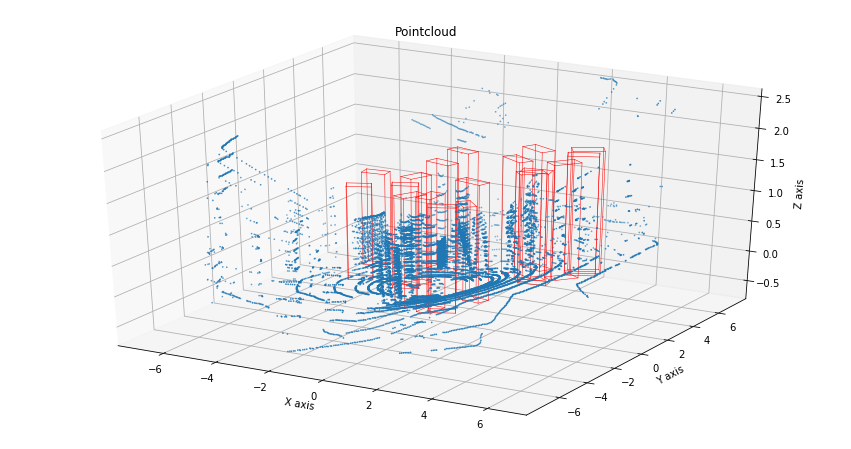

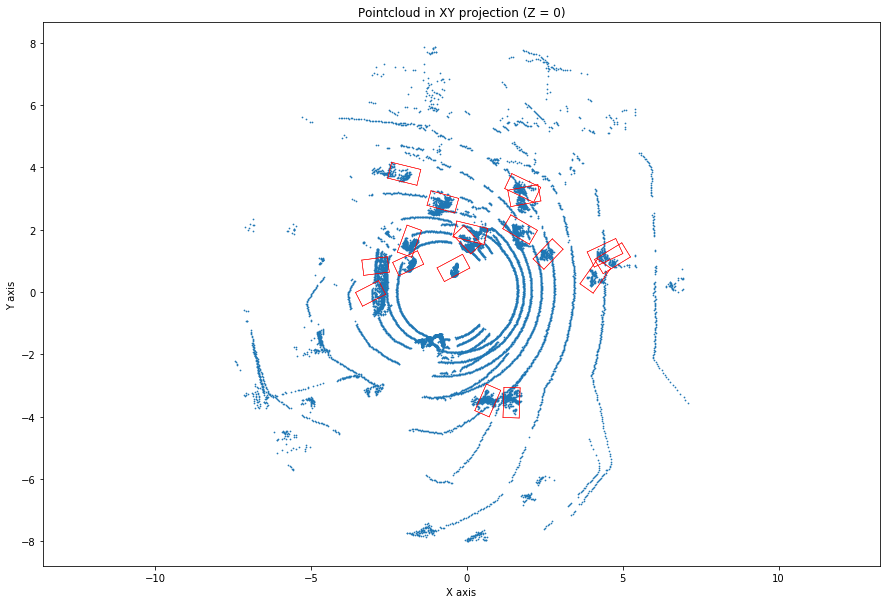

In [14]:
plt.ion() 
plt.show()

### Main loop

In [ ]:
step_viz = 4
num_between_logs = 1000

In [ ]:
for seq_idx in range(cb_data.nr_seqs()):

    seq = cb_data.seqs[seq_idx]
    print(
        "({}/{}): {} with {} frames".format(
            seq_idx + 1, cb_data.nr_seqs(), seq, cb_data.nr_frames(seq_idx)
        )
    )
    
    # seq dest: data/xxxx_processed/viz_imgs/seq
    img_seq_dir = os.path.join(cb_data.media_dir, 'img_mpl', seq)
    # print(img_seq_dir)
    
    if not os.path.exists(img_seq_dir):
        print("Images will be saved in {}".format(img_seq_dir))
        os.makedirs(img_seq_dir, exist_ok=True)

        # pose_stamped based visualization
        tf_qolo_dir = os.path.join(cb_data.source_data_dir, "tf_qolo")
        lidar_stamped_path = os.path.join(tf_qolo_dir, seq + "_tfqolo_sampled.npy")
        lidar_pose_stamped = np.load(lidar_stamped_path, allow_pickle=True).item()

        # generate image every step_viz frames
        for fr_idx in range(0, cb_data.nr_frames(seq_idx), step_viz):
            # input a series of poses
            trans = lidar_pose_stamped["position"][: fr_idx + 1]
            rot_quat = lidar_pose_stamped["orientation"][: fr_idx + 1]

            lidar, dets, dets_conf, trks = cb_data[seq_idx, fr_idx]
            figpath = os.path.join(img_seq_dir, "{0:04d}.png".format(fr_idx))
            
            
            if fr_idx % num_between_logs == 0:
                print(
                    "({}/{}): {:1f}% remaining".format(
                        fr_idx // step_viz + 1,
                        cb_data.nr_frames(seq_idx) // step_viz + 1,
                        100
                        - (50 * fr_idx + 100) / (cb_data.nr_frames(seq_idx) // 2 + 1),
                    )
                )
            
            # plot_world_frame(lidar.T, (trans, rot_quat), trks, figpath)
            pass
    else:
        print("{} images already generated!!!".format(cb_data.seqs[seq_idx]))
        continue


## Archive

In [33]:
def display_frame_statistics(
    pc, boxes3d, points=0.2, plotting=True
):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.

    Parameters
    ----------
    pc              : raw pointcloud
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    plotting        : Plot the final image or not
    dataset         : `raw` dataset. (deprecated)
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates. (deprecated)
    frame           : Absolute number of the frame. (deprecated)
    """
    
    """
    dataset_gray = list(dataset.gray)
    dataset_rgb = list(dataset.rgb)
    dataset_velo = list(dataset.velo)

    print('Frame timestamp: ' + str(dataset.timestamps[frame]))

    # Draw camera data
    f, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0, 0].imshow(dataset_gray[frame][0], cmap='gray')
    ax[0, 0].set_title('Left Gray Image (cam0)')
    ax[0, 1].imshow(dataset_gray[frame][1], cmap='gray')
    ax[0, 1].set_title('Right Gray Image (cam1)')
    ax[1, 0].imshow(dataset_rgb[frame][0])
    ax[1, 0].set_title('Left RGB Image (cam2)')
    ax[1, 1].imshow(dataset_rgb[frame][1])
    ax[1, 1].set_title('Right RGB Image (cam3)')
    plt.show()

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]
    """

    def draw_point_cloud(
        ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None
    ):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        # ax.scatter(
        #     *np.transpose(velo_frame[:, axes]),
        #     s=point_size,
        #     c=velo_frame[:, 3],
        #     cmap='gray'
        # )
        ax.scatter(
            *np.transpose(pc[:, axes]),
            s=point_size,
            c=pc[:, 3],
            cmap='gray'
        )
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d != None:
            ax.set_xlim3d(xlim3d)
        if ylim3d != None:
            ax.set_ylim3d(ylim3d)
        if zlim3d != None:
            ax.set_zlim3d(zlim3d)

        # for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        #     draw_box(ax, t_rects, axes=axes, color=colors[t_type])
        num = len(boxes3d)
        for n in range(num):
            b = boxes3d[n].T
            draw_box(ax, b, axes=axes, color='r')

    # Draw point cloud data as 3D plot
    fig3d = plt.figure(figsize=(15, 8))
    ax3d = fig3d.add_subplot(111, projection='3d')
    draw_point_cloud(ax3d, 'Velodyne scan', xlim3d=(-10, 30))
    if plotting:
        plt.show()

    # Draw point cloud data as plane projections
    fig_proj, ax_proj = plt.subplots(3, 1, figsize=(15, 25))
    draw_point_cloud(
        ax3[0],
        'Velodyne scan, XZ projection (Y = 0), the car is moving in direction left to right',
        axes=[0, 2],  # X and Z axes
    )
    draw_point_cloud(
        ax3[1],
        'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right',
        axes=[0, 1],  # X and Y axes
    )
    draw_point_cloud(
        ax3[2],
        'Velodyne scan, YZ projection (X = 0), the car is moving towards the graph plane',
        axes=[1, 2],  # Y and Z axes
    )
    if plotting:
        plt.show()

    return fig3d, fig_proj